# GP2 Tutorial - Module 4 - How to Interact with Clinical Data

`GP2 ❤️ Open Science 😍`

- **Module:** GP2 Demo
- **Authors:** Sara Bandres-Ciga, Hampton Leonard, and Mary Makarious on behalf of the Global Parkinson's Genetics Program
- **Estimated Computation and Runtime:** 
    - **Estimated Specifications:** Default; 1 CPU, 3.75 GB Memory, 50 GB Persistent Disk Size
    - **Estimated Runtime:** 20 min.
- **Date Last Updated:** 29-AUGUST-2022
    - **Update Description:** Updating notebook for GP2 release 2.0
    
---
### Quick Description
These notebooks serve as a beginner's introduction to Terra, GP2, and AMP-PD data to help you get comfortable navigating the spaces, manage your costs, upload your own data, and begin running some simple analyses.


### Course Summary
- **Module 1:** Intro + demo Terra
- **Module 2:** Introduction to current AMP and GP2 data + managing costs
- **Module 3:** How to upload, access, and copy over data 
- **Module 4:** How to interact with clinical data + make mini covariate files **(this notebook!)**
- **Module 5:** Analysis example 1: Run PRS with PD known hits in Non-Euro pops and data viz + save results
- **Module 6:** Analysis example 2: How to extract a gene, annotate it, run burden, and get hmz and compound hets + save results
- **Module 7:** WDL workflows: What they are + When to use + Quick example overview

--- 
## Notebook Summary 
- Getting Started
- Data Overview
- How to pull clinical information from AMP-PD
- Making a very basic covariate file from AMP-PD data
- How to pull clinical information from GP2
- Making a very basic covariate file from GP2 data
- Downloading PLINKv1.9 and PLINKv2.0
- Using PLINKv1.9 to subset data from AMP
- Using PLINKv1.9 to subset data from GP2

## Workflow

### [Getting Started](#1)
This section goes through: 
- Functions needed to interact between Terra and the cloud

### [Data Overview](#2)
This section goes through:
- Quick overview access AMP-PD data
- Quick overview of GP2 data

### [How to Pull Clinical Information From AMP-PD](#3)
This section goes through:
- How to print out the available information AMP has 
- How to list out all files
- How to make a working directory to copy your files of interest to

### [Making a Very Basic Covariate File From AMP-PD Data](#4)
This section goes through:
- Pulling updated latest diagnosis information
- Coding the proper PHENO information
- Extracting the study arm information from Enrollment file
- Extracting age at baseline and sex information from Demographics file
- Coding the sex information
- Merging and making small covariate file
- Overview of cohort and pheno
- Overview of age at baseline for cases 
- Overview of race

### [How to Pull Clinical Information From GP2](#5)
This section goes through:
- Pulling the clinical information GP2 has available

### [Making a Very Basic Covariate File From GP2 Data](#6)
This section goes through:
- Subsetting from the GP2 clinical file
- Renaming columns
- Coding for phenotype
- Overview of cohort and pheno


# Getting Started

## Load Libraries

In [1]:
# Use the os package to interact with the environment
import os
import sys

# Bring in Pandas for Dataframe functionality
import pandas as pd
from functools import reduce

# Bring some visualization functionality 
import seaborn as sns

# numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

## Create Python Functions to Interact With GCP/Terra
Terra is an intermediate platform, designed to help the user interact with the data placed in Google Cloud buckets.

In [2]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}', file=sys.stderr)
    !$command
    
def shell_return(command):
    print(f'Executing: {command}', file=sys.stderr)
    output = !$command
    return '\n'.join(output)

# Utility routine for printing a query before executing it
def bq_query(query):
    print(f'Executing: {query}', file=sys.stderr)
    return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)

## Initialize Workspace Variables

In [3]:
# Set up billing project and data path variables
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

## AMP-PD v2.5
## Explicitly define release v2.5 path 
AMP_RELEASE_PATH = 'gs://amp-pd-data/releases/2021_v2-5release_0510'
AMP_CLINICAL_RELEASE_PATH = f'{AMP_RELEASE_PATH}/clinical'

AMP_WGS_RELEASE_PATH = 'gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs'
AMP_WGS_RELEASE_PLINK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'plink')
AMP_WGS_RELEASE_GATK_PATH = os.path.join(AMP_WGS_RELEASE_PATH, 'gatk')

## Print the information to check we are in the proper release and billing 
## This will be different for you, the user, depending on the billing project your workspace is on
print('Billing and Workspace')
print(f'Workspace Name: {WORKSPACE_NAME}')
print(f'Billing Project: {BILLING_PROJECT_ID}')
print(f'Workspace Bucket, where you can upload and download data: {WORKSPACE_BUCKET}')
print('')

print('AMP-PD v2.5')
print(f'Path to AMP-PD v2.5 Clinical Data: {AMP_CLINICAL_RELEASE_PATH}')
print(f'Path to AMP-PD v2.5 WGS Data: {AMP_WGS_RELEASE_PLINK_PATH}')
print('')

## GP2 v2.0
## Explicitly define release v2.0 path 
GP2_RELEASE_PATH = 'gs://gp2tier2/release2_06052022'
GP2_CLINICAL_RELEASE_PATH = f'{GP2_RELEASE_PATH}/clinical_data'
GP2_META_RELEASE_PATH = f'{GP2_RELEASE_PATH}/meta_data'
GP2_SUMSTAT_RELEASE_PATH = f'{GP2_RELEASE_PATH}/summary_statistics'

GP2_RAW_GENO_PATH = f'{GP2_RELEASE_PATH}/raw_genotypes'
GP2_IMPUTED_GENO_PATH = f'{GP2_RELEASE_PATH}/imputed_genotypes'
print('GP2 v2.0')
print(f'Path to GP2 v2.0 Clinical Data: {GP2_CLINICAL_RELEASE_PATH}')
print(f'Path to GP2 v2.0 Raw Genotype Data: {GP2_RAW_GENO_PATH}')
print(f'Path to GP2 v2.0 Imputed Genotype Data: {GP2_IMPUTED_GENO_PATH}')

Billing and Workspace
Workspace Name: GP2 Bioinformatics Course 2
Billing Project: terra-9b559320
Workspace Bucket, where you can upload and download data: gs://fc-c04486b2-8d7e-4359-a607-63643e9a7914

AMP-PD v2.5
Path to AMP-PD v2.5 Clinical Data: gs://amp-pd-data/releases/2021_v2-5release_0510/clinical
Path to AMP-PD v2.5 WGS Data: gs://amp-pd-genomics/releases/2021_v2-5release_0510/wgs/plink

GP2 v2.0
Path to GP2 v2.0 Clinical Data: gs://gp2tier2/release2_06052022/clinical_data
Path to GP2 v2.0 Raw Genotype Data: gs://gp2tier2/release2_06052022/raw_genotypes
Path to GP2 v2.0 Imputed Genotype Data: gs://gp2tier2/release2_06052022/imputed_genotypes


# Data Overview

### Paths to AMP-PD Buckets 
From AMP-PD's Getting Started workspaces

Raw files are stored in [Google Cloud Storage](https://cloud.google.com/storage/) buckets:

- [gs://amp-pd-data](https://console.cloud.google.com/storage/browser/amp-pd-data): Clinical data files and other participant metadata
- [gs://amp-pd-data-tier2](https://console.cloud.google.com/storage/browser/amp-pd-data-tier2): Clinically reported genetic mutations and other restricted-access participant metadata
- [gs://amp-pd-genomics](https://console.cloud.google.com/storage/browser/amp-pd-genomics): Whole Genome sequencing CRAMs, VCFs, and metrics files
- [gs://amp-pd-transcriptomics](https://console.cloud.google.com/storage/browser/amp-pd-transcriptomics): Transcriptomics FASTQs, BAMs, Quantification, and Feature Counts files for single samples and QC pools
- [gs://amp-pd-proteomics](https://console.cloud.google.com/storage/browser/amp-pd-proteomics): Proteomics preview release with eight unfiltered NPX files from four separate assays for matched Plasma and CSF samples
- More information here: https://amp-pd.org/data 
        
### AMP-PD Bucket Structure - Overview

In Tier 2, the structure looks like the following
```
{GS_RELEASE_PATH} @ gs://amp-pd-data/releases/2021_v2-5release_0510
    ├── amp_pd_case_control.csv
    ├── amp_pd_participant_wgs_duplicates.csv
    ├── amp_pd_participants.csv
    ├── rna_sample_inventory.csv
    ├── wgs_gatk_joint_genotyping_samples.csv
    ├── wgs_sample_inventory.csv
    └── clinical/
            └── [58 files]
```

### Paths to GP2 Buckets (Release 2)

Raw files are stored in [Google Cloud Storage](https://cloud.google.com/storage/) buckets:

#### Tier 1 
- [gs://gp2_tier1/release2_06052022](https://console.cloud.google.com/storage/browser/gp2tier1/release2_06052022): Tier 1 Bucket
- [gs://gp2_tier1/release2_06052022/summary_statistics/](https://console.cloud.google.com/storage/browser/gp2_tier1/release2_06052022/summary_statistics): Summary statistics 

#### Tier 2 
- [gs://gp2_tier2/release2_06052022/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/): Tier 2 bucket
- [gs://gp2_tier2/release2_06052022/summary_statistics/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/summary_statistics): Summary statistics 
- [gs://gp2_tier2/release2_06052022/raw_genotypes/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/raw_genotypes): Raw genotypes (PLINKv2 files - pgen files broken down by ancestry)
- [gs://gp2_tier2/release2_06052022/imputed_genotypes/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/imputed_genotypes): Imputed genotypes (PLINKv2 files - pgen files broken down by ancestry)
- [gs://gp2_tier2/release2_06052022/cnvs/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/cnvs): Probabilistic estimates of copy number variation per gene 
- [gs://gp2_tier2/release2_06052022/clinical_data/](https://console.cloud.google.com/storage/browser/gp2tier2/release2_06052022/clinical_data/): Clinical data and dictionary 
- [gs://gp2_tier2/release2_06052022/meta_data/](https://console.cloud.google.com/storage/browser/gp2_tier2/release2_06052022/meta_data): Meta data (hdf5 file with QC, ancestry, principle components, etc)

### GP2 Bucket Structure - Overview

```
gp2_tier1
	└── summary_statistics/

gp2_tier2
	├── raw_genotypes/
	├── imputed_genotypes/
	├── cnvs/
	├── meta_data/
	├── clinical_data/
	└── summary_statistics/
```

**for more information, please see Modules 1 and 2 in this series!**

# How to Pull Clinical Information From AMP-PD

We went through these steps in the last module, but putting them here for clarity :) 

In [4]:
# Create a folder on your workspace to copy to 
print("Making a working directory")
WORK_DIR = f'/home/jupyter/AMP_COV_FILE'
shell_do(f'mkdir -p {WORK_DIR}')

# Check directories where AMP-PD data are 
print("List available information in AMP-PD")
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {AMP_RELEASE_PATH}')

print("List available clinical information in AMP-PD")
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {AMP_CLINICAL_RELEASE_PATH}')

Making a working directory


Executing: mkdir -p /home/jupyter/AMP_COV_FILE


List available information in AMP-PD


Executing: gsutil -u terra-9b559320 ls gs://amp-pd-data/releases/2021_v2-5release_0510


gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_case_control.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_participant_wgs_duplicates.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_participants.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/rna_sample_inventory.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/wgs_gatk_joint_genotyping_samples.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/wgs_sample_inventory.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/
List available clinical information in AMP-PD


Executing: gsutil -u terra-9b559320 ls gs://amp-pd-data/releases/2021_v2-5release_0510/clinical


gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_CSF_abeta_tau_ptau.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_CSF_abeta_tau_ptau_dictionary.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_CSF_beta_glucocerebrosidase.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_CSF_beta_glucocerebrosidase_dictionary.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_SomaLogic_plasma.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_SomaLogic_plasma_dictionary.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_other.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Biospecimen_analyses_other_dictionary.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Caffeine_history.csv
gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Caffeine_history_dictiona

In [5]:
# An example to copy files to your from your bucket workspace to your notebook workspace
print("Copy over files from bucket to VM workspace")
print("WARNING! This VM, when deleted, deletes all data copied over to it")
print("If you want to store results or files long-term, copy them to your bucket (more in Modules 5 and 6)")

shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {AMP_RELEASE_PATH}/amp_pd_case_control.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {AMP_CLINICAL_RELEASE_PATH}/Enrollment.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {AMP_CLINICAL_RELEASE_PATH}/Demographics.csv {WORK_DIR}')

Copy over files from bucket to VM workspace
WARNING! This VM, when deleted, deletes all data copied over to it
If you want to store results or files long-term, copy them to your bucket (more in Modules 5 and 6)


Executing: gsutil -u terra-9b559320 -m cp -r gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_case_control.csv /home/jupyter/AMP_COV_FILE


Copying gs://amp-pd-data/releases/2021_v2-5release_0510/amp_pd_case_control.csv...
/ [1/1 files][732.1 KiB/732.1 KiB] 100% Done                                    
Operation completed over 1 objects/732.1 KiB.                                    


Executing: gsutil -u terra-9b559320 -m cp -r gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Enrollment.csv /home/jupyter/AMP_COV_FILE


Copying gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Enrollment.csv...
/ [1/1 files][632.4 KiB/632.4 KiB] 100% Done                                    
Operation completed over 1 objects/632.4 KiB.                                    


Executing: gsutil -u terra-9b559320 -m cp -r gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Demographics.csv /home/jupyter/AMP_COV_FILE


Copying gs://amp-pd-data/releases/2021_v2-5release_0510/clinical/Demographics.csv...
/ [1/1 files][635.3 KiB/635.3 KiB] 100% Done                                    
Operation completed over 1 objects/635.3 KiB.                                    


As you can see...
- AMP keeps the phenotype information in a different bucket `{AMP_RELEASE_PATH}/amp_pd_case_control.csv`
- there's a variety of information captured in `{AMP_CLINICAL_RELEASE_PATH}` like demographic information, UPDRS scores, RBD Questionnaire, DaTSCAN... we just copied over enrollment and demographic information
- Related individuals are still present here

# Making a Very Basic Covariate File From AMP-PD Data

## Most Recent Diagnosis and Case/Control Assignment

In [6]:
# Read in the clinical information
pd_case_control_df = pd.read_csv(f'{WORK_DIR}/amp_pd_case_control.csv')

# Uncomment the following line to look at the dataframe
#pd_case_control_df.head()

For analyses, it's generally good practice to keep the latest diagnosis per individual to account for possible misdiagnosis early on in disease onset.

You can subset and only latest diagnosis by doing the following:

In [7]:
# Subsetting to keep only a few columns 
pd_case_control_latest_df = pd_case_control_df[['participant_id', 'diagnosis_latest', 'case_control_other_latest']].copy()

# Renaming the columns 
pd_case_control_latest_df.columns = ['ID', 'LATEST_DX', 'CASE_CONTROL']

# Printing a few numbers to get an overview of how many cases, controls, and other phenotypes listed in the AMP-PD data
print(pd_case_control_latest_df['CASE_CONTROL'].value_counts())

Control    4312
Case       3527
Other      2933
Name: CASE_CONTROL, dtype: int64


In [8]:
# Print an overview of the latest diagnosis column
print(pd_case_control_latest_df['LATEST_DX'].value_counts())

No PD Nor Other Neurological Disorder        4312
LBD                                          2614
Parkinson's Disease                          2392
Idiopathic PD                                1135
Multiple System Atrophy                        71
Progressive Supranuclear Palsy                 61
Essential Tremor                               47
Prodromal non-motor PD                         36
Prodromal motor PD                             36
Other Neurological Disorder(s)                 30
Dementia With Lewy Bodies                      14
Corticobasal Degeneration                       8
Neuroleptic-Induced Parkinsonism                3
Parkinsonism                                    3
Possible Alzheimer's Disease                    3
Vascular Parkinsonism                           2
Fahr's Syndrome                                 1
Alzheimer's Disease                             1
Psychogenic Illness                             1
Juvenile Autosomal Recessive Parkinsonism       1


### Cohort Information 

Let's make a column of just COHORT names, so your analyses can be adjusted by the cohort they came from. 

AMP-PD uses the following naming convention: 
- Samples with the `LB-` prefix come from the **LBD** cohort; more information [here](https://amp-pd.org/unified-cohorts/lbd)
- Samples with the `PP-` prefix come from the **PPMI** cohort; more information [here](https://amp-pd.org/unified-cohorts/ppmi)
- Samples with the `PD-` prefix come from the **PDBP** cohort; more information [here](https://amp-pd.org/unified-cohorts/pdbp)
- Samples with the `HB-` prefix come from the **HBS** cohort; more information [here](https://amp-pd.org/unified-cohorts/hbs)
- Samples with the `LC-` prefix come from the **LCC** cohort; more information [here](https://amp-pd.org/unified-cohorts/llc)
- Samples with the `BF-` prefix come from the **BioFIND** cohort; more information [here](https://amp-pd.org/unified-cohorts/biofind)
- Samples with the `SU-` prefix come from the **SURE-PD3** cohort; more information [here](https://amp-pd.org/unified-cohorts/sure-pd3)
- Samples with the `SY-` prefix come from the **STEADY-PD3** cohort; more information [here](https://amp-pd.org/unified-cohorts/steady-pd-3)

In [9]:
# Add cohort column based on study prefix (Numpy's NAN for anything missing - though nothing should be missing)
pd_case_control_latest_df['COHORT']= np.where(pd_case_control_latest_df.ID.str.contains("LB-"), "LBD",
                                    np.where(pd_case_control_latest_df.ID.str.contains("PP-"), "PPMI",
                                    np.where(pd_case_control_latest_df.ID.str.contains("PD-"), "PDBP",
                                    np.where(pd_case_control_latest_df.ID.str.contains("HB-"), "HBS",
                                    np.where(pd_case_control_latest_df.ID.str.contains("LC-"), "LCC",
                                    np.where(pd_case_control_latest_df.ID.str.contains("BF-"), "BIOFIND",
                                    np.where(pd_case_control_latest_df.ID.str.contains("SU-"), "SURE-PD3",
                                    np.where(pd_case_control_latest_df.ID.str.contains("SY-"), "STEADY-PD3", np.nan))))))))

In [10]:
# Look at the abbreviated dataframe 
#pd_case_control_latest_df.head()

### Phenotype
Here, we will add a **phenotype column** based on the case/control column 

In [10]:
# Add PHENO
case_con_reduced = pd_case_control_latest_df.copy()
case_con_reduced.drop_duplicates(subset=['ID'], inplace=True)

## Outline the conditions 
conditions = [
    (case_con_reduced['CASE_CONTROL'] == "Case"),
    (case_con_reduced['CASE_CONTROL'] == "Control")]

## Assign conditions so case=2 and controls=1, and -9 otherwise (matching PLINK convention)
choices = [2,1]
case_con_reduced['PHENO'] = np.select(conditions, choices, default=-9).astype(np.int64)

# Clean up dataframe (reset the index)
case_con_reduced.reset_index(inplace=True)
case_con_reduced.drop(columns=["index"], inplace=True)

# Drop the case/control categorical column 
case_con_reduced.drop(columns=['CASE_CONTROL'], inplace=True)

# Print out the PHENO counts
print(case_con_reduced['PHENO'].value_counts(dropna=False))

# Print the size of the dataframes (# rows, # columns)
print(case_con_reduced.shape)

 1    4312
 2    3527
-9    2933
Name: PHENO, dtype: int64
(10772, 4)


This shows that we have about
- 4,312 controls; matching the number of `No PD Nor Other Neurological Disorder`
- 3,527 cases; matching the number of `Parkinson's Disease` and `Idiopathic PD` counts listed in the case/control file
- 2,933 "other" phenotypes (please see above for an overview of these, the majority being `LBD`)


We will leave in the latest diagnosis as a categorical variable, in case you want to recode the PHENO column to something other than PD cases and controls or subset for downstream analyses.


This is a good start, but let's add some more information...

## Enrollment Data
This step is to extract the enrollment information per patient, such as if they were prodromal or part of a genetic ancestry

In [11]:
# Let's load in the Enrollment.csv as a dataframe
enrollment_df = pd.read_csv(f'{WORK_DIR}/Enrollment.csv')

# Subset a few key columns 
enrollment_subset_df = enrollment_df[['participant_id', 'study_arm']].copy()

# and rename them to merge them easily later
enrollment_subset_df.columns = ['ID', 'ENROLL_STUDY_ARM']

# Let's drop any repeated IDs at this stage 
enrollment_subset_df.drop_duplicates(subset=['ID'], keep='first', inplace=True)

# Print the different study arms captured in AMP-PD
print(enrollment_subset_df['ENROLL_STUDY_ARM'].value_counts(dropna=False))

# Print the size of the dataframe (# rows, # columns)
print(enrollment_subset_df.shape)

Healthy Control                3377
PD                             2705
LBD                            2521
Genetic Cohort Unaffected       403
Genetic Cohort PD               272
Genetic Registry Unaffected     245
Genetic Registry PD             196
Disease Control                 159
SWEDD                            77
Prodromal                        64
NaN                               3
Unknown                           1
Name: ENROLL_STUDY_ARM, dtype: int64
(10023, 2)


In [12]:
# Have a glance at what the dataframe looks like now 
#enrollment_subset_df.head()

We will leave this column as categorical, as before analyses you might want to subset specific special cases (such as those involved in a genetic registry) to be analyzed separately. 

## Demographics Data

There's a lot of information here, but we will pull out sex and code it (1=Male, 2=Female)

In [19]:
# Let's load in the medical history as a dataframe 
demographics_df = pd.read_csv(f'{WORK_DIR}/Demographics.csv')

# Rename the columns for ease of merging later 
demographics_df.rename(columns = {'participant_id':'ID'}, inplace = True)
demographics_df.rename(columns = {'age_at_baseline':'BASELINE_AGE'}, inplace = True)
demographics_df.rename(columns = {'race':'RACE'}, inplace = True)

# Have a glance at the dataframe 
#demographics_df.head()

In [20]:

# Sort by visit month, and drop duplicate IDs (therefore dropping subsequent follow-ups)
demographics_baseline_df = demographics_df \
.sort_values('visit_month', ascending=True) \
.drop_duplicates('ID').sort_index()

# Merge most recent case/control assignment to the demographics so we can subset by case/control
demographics_df_casecon = demographics_df.merge(case_con_reduced, on='ID', how='outer')

# Look at the new merged dataframe
#demographics_df_casecon.head()

In [21]:
# Code the different sexes
conditions = [
     (demographics_df_casecon['sex'] == "Male"),
     (demographics_df_casecon['sex'] == "Female")]

# 1=male; 2=female
choices = [1,2]

# Make new quantitative column 
demographics_df_casecon['SEX'] = np.select(conditions, choices, default=None).astype(np.int64)

# Drop the categorical column
#demographics_df_casecon.drop(columns=['sex'], inplace=True)

In [22]:
# Have a look at the data
#demographics_df_casecon.head()

In [23]:
## Keep the columns of interest 
demographics_df_casecon_toKeep = demographics_df_casecon[['ID', 'PHENO', 'SEX', 'RACE',
                                                          'BASELINE_AGE', 'LATEST_DX',
                                                          'COHORT']].copy()
#demographics_df_casecon_toKeep.head()

## Merging with the Enrollment Arm Information

In [24]:
# Merge the cleaned PHENO file with the enrollment information 
enrollment_pheno_df = demographics_df_casecon_toKeep.merge(enrollment_subset_df, on='ID', how='outer')

# Make FID column 
enrollment_pheno_df['FID'] = enrollment_pheno_df['ID'].values 

# Rename ID to IID 
enrollment_pheno_df.rename(columns = {'ID':'IID'}, inplace = True)

# Reorder dataframe
reorder_enrollment_pheno_df = enrollment_pheno_df[['FID', 'IID', 'PHENO',
                                                  'SEX', 'RACE', 'BASELINE_AGE', 'LATEST_DX',
                                                  'COHORT', 'ENROLL_STUDY_ARM']].copy()

# Glance at the merged dataframe
#reorder_enrollment_pheno_df.head()

## Cohort and Case Overview 

In [25]:
# Get an overview of number of cases and controls per cohort 
reorder_enrollment_pheno_df.groupby(['COHORT','ENROLL_STUDY_ARM'])['PHENO'].value_counts()

COHORT      ENROLL_STUDY_ARM             PHENO
BIOFIND     Healthy Control               1         89
                                         -9          6
            PD                            2        118
HBS         Healthy Control               1        537
            PD                            2        649
LBD         Healthy Control               1       1972
            LBD                          -9       2521
PDBP        Disease Control              -9        155
                                          2          3
                                          1          1
            Healthy Control               1        542
                                         -9          1
            PD                            2        873
                                         -9         13
            Unknown                       2          1
PPMI        Genetic Cohort PD             2        267
                                         -9          4
                  

## Age Distribution Overview
Let's see the distribution of age at baseline for cases only

<AxesSubplot:xlabel='BASELINE_AGE', ylabel='Count'>

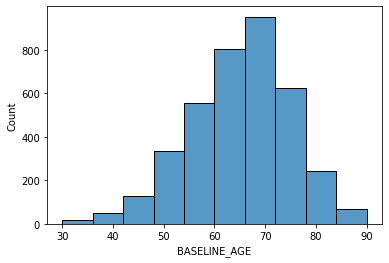

In [26]:
cases_df = reorder_enrollment_pheno_df.query('PHENO==2')['BASELINE_AGE']
cases_df.head()
sns.histplot(cases_df, bins=10)

## Race Overview 

In [27]:
reorder_enrollment_pheno_df.groupby(['RACE', 'PHENO'])['SEX'].value_counts()

RACE                                       PHENO  SEX
American Indian or Alaska Native            1     1         1
                                                  2         1
                                            2     1         3
Arab                                        2     1         2
Asian                                      -9     1         1
                                                  2         1
                                            1     2         7
                                                  1         2
                                            2     1        24
                                                  2        13
Black or African American                  -9     1         5
                                                  2         1
                                            1     2        47
                                                  1        31
                                            2     2        24
                

## All done! You've just made a small covariate file with the AMP-PD Data!

# How to Pull Clinical Information From GP2

GP2 only has one clinical file so far, so it's a little easier to work with

It's important to note AMP-PD and GP2 don't have similar structures, so you need to spend time looking for what you need.

In [28]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls {GP2_CLINICAL_RELEASE_PATH}')

Executing: gsutil -u terra-9b559320 ls gs://gp2tier2/release2_06052022/clinical_data


gs://gp2tier2/release2_06052022/clinical_data/master_key_release2_final.csv
gs://gp2tier2/release2_06052022/clinical_data/release2_26042022_data_dictionary.csv


In [29]:
# Create a folder on your workspace to copy to 
print("Making a working directory")
WORK_DIR = f'/home/jupyter/GP2_COV_FILE'
shell_do(f'mkdir -p {WORK_DIR}')

Making a working directory


Executing: mkdir -p /home/jupyter/GP2_COV_FILE


In [30]:
print("Copy over files from bucket to VM workspace")
print("WARNING! This VM, when deleted, deletes all data copied over to it")
print("If you want to store results or files long-term, copy them to your bucket (more in Modules 5 and 6)")

shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_CLINICAL_RELEASE_PATH}/master_key_release2_final.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_CLINICAL_RELEASE_PATH}/release2_26042022_data_dictionary.csv {WORK_DIR}')

Copy over files from bucket to VM workspace
WARNING! This VM, when deleted, deletes all data copied over to it
If you want to store results or files long-term, copy them to your bucket (more in Modules 5 and 6)


Executing: gsutil -u terra-9b559320 -m cp -r gs://gp2tier2/release2_06052022/clinical_data/master_key_release2_final.csv /home/jupyter/GP2_COV_FILE


Copying gs://gp2tier2/release2_06052022/clinical_data/master_key_release2_final.csv...
/ [1/1 files][656.7 KiB/656.7 KiB] 100% Done                                    
Operation completed over 1 objects/656.7 KiB.                                    


Executing: gsutil -u terra-9b559320 -m cp -r gs://gp2tier2/release2_06052022/clinical_data/release2_26042022_data_dictionary.csv /home/jupyter/GP2_COV_FILE


Copying gs://gp2tier2/release2_06052022/clinical_data/release2_26042022_data_dictionary.csv...
/ [1/1 files][  1.5 KiB/  1.5 KiB] 100% Done                                    
Operation completed over 1 objects/1.5 KiB.                                      


# Making a Very Basic Covariate File From GP2 Data
- Related individuals are still present here

In [31]:
# Let's load in the medical history as a dataframe 
gp2_clinical_df = pd.read_csv(f'{WORK_DIR}/master_key_release2_final.csv')

# Have a look at the dataframe
#gp2_clinical_df.head()

In [32]:
# Print out the columns 
gp2_clinical_df.columns

Index(['GP2ID', 'GP2sampleID', 'manifest_id', 'Phenotype', 'sex_for_qc', 'age',
       'age_of_onset', 'age_at_diagnosis', 'age_at_death', 'race_for_qc',
       'family_history_for_qc', 'region_for_qc'],
      dtype='object')

In [33]:
## For example, let's keep only a handful of information 
gp2_data_toKeep_df = gp2_clinical_df[['GP2sampleID',
                                      'Phenotype', 'sex_for_qc', 'age','age_of_onset',
                                      'race_for_qc']].copy()

# Rename columns 
gp2_data_toKeep_df.rename(columns = {'GP2sampleID': 'IID',
                                     'sex_for_qc':'SEX', 
                                     'age':'AGE', 
                                     'race_for_qc':'RACE',
                                     'age_of_onset':'AAO'}, inplace = True)

# Have a look at the abbreviated dataframe
#gp2_data_toKeep_df.head()

In [34]:
# Have a look at the reported phenotypes
gp2_data_toKeep_df['Phenotype'].value_counts(dropna=False)

PD              5639
Control         3661
Other              6
Not Reported       3
Name: Phenotype, dtype: int64

## Coding Phenotype

In [35]:
# Add PHENO
gp2_data_pheno_toKeep_df = gp2_data_toKeep_df.copy()

## Outline the conditions 
conditions = [
    (gp2_data_pheno_toKeep_df['Phenotype'] == "PD"),
    (gp2_data_pheno_toKeep_df['Phenotype'] == "Control")]

## Assign conditions so case=2 and controls=1, and -9 otherwise (matching PLINK convention)
choices = [2,1]
gp2_data_pheno_toKeep_df['PHENO'] = np.select(conditions, choices, default=-9).astype(np.int64)

# Clean up dataframe (reset the index)
gp2_data_pheno_toKeep_df.reset_index(inplace=True)
gp2_data_pheno_toKeep_df.drop(columns=["index"], inplace=True)

# Drop the case/control categorical column 
gp2_data_pheno_toKeep_df.drop(columns=['Phenotype'], inplace=True)

# Print out the PHENO counts
print(gp2_data_pheno_toKeep_df['PHENO'].value_counts(dropna=False))

 2    5639
 1    3661
-9       9
Name: PHENO, dtype: int64


In [36]:
# Let's get case-control numbers by race and sex
gp2_data_pheno_toKeep_df.groupby(['RACE','SEX'])['PHENO'].value_counts()

RACE                                       SEX           PHENO
American Indian or Alaska Native           Female         1         10
                                                          2          4
                                           Male           2          7
                                                          1          3
Asian                                      Female         1        155
                                                          2         90
                                           Male           2         99
                                                          1         83
                                           Not Reported   2          1
Black or African American                  Female         1        320
                                                          2         40
                                           Male           1        236
                                                          2         62
Multi-racial  

In [32]:
# Have a look at your covariate file
#gp2_data_pheno_toKeep_df.head()

## All done! You've just made a small covariate file with the GP2 Data!